# Common-Ownership and Television Programming
## Why is Law & Order the only thing on?

Most traditional television networks like ABC, The History Channel, and HBO are owned by a parent company that owns several networks such as Disney, Comcast and ViacomCBS. Networks are often bought and sold between parent companies changing the portfolio of networks and begging the question: Does the choice of networks in a portfolio involve competitive product differentiation? For example, when Disney purchased Fox Family from Fox in 2001 was Disney looking to broaden the type of programming in its portfolio or produce more similar content to their existing portfolio?

Two Theories:  
1. Minimal Differentiation - Programmers choose content that is like their competitors' and split audiences.
2. Maximal Differentiation - Programmers make choices to distinct content to attract audiences away from competitors.

This project analyzes prime-time television programming schedules to understand how firms position their content by choosing the genre of their programming compared to competitors.

# Table of contents
1. [Data](#data)
    1. [Program Schedule](#scheduledata)
    2. [Ownership](#ownership)
    4. [Data Issues](#dataissues)
2. [Measuring Differentiation](#differentiation)
3. [Analysis](#analysis)
    1. [Mergers in 2013](#merge2013)
---

# Data <a name="data"></a>

<div>
    <img style="float: right;" src ="attachment:TVListings.jpg" width="500"> 
</div>  

The television programming data used for this project was scraped from [TVTango.com](http://www.tvtango.com) a website that publishes nightly tv schedules in addition to tv news. Below you can see an example of the types of information included in the scrape. Most importantly it includes the network, the name of each show, and the length of the show. While some schedules included ratings information collected from Nielsen that data was limited to broadcast networks for most of the time period.
  
I combined the scraped schedules with genre categories obtained from [IMDB's](http://imdb.com) database of television shows and movies. Each show was attached to the first genre listed, but I consolidated the total number of genres as seen below.

This data set covers the full calendar years from 2007 to 2016 comprising ten years of schedules. A noticeable absence is content from streaming platforms like Netflix and Hulu. It's interesting to note that Netflix started its online streaming product in 2007, but didn't produce original content until 2013. Because streaming platforms do not create programming schedules in the same ways that linear television networks do they are excluded from this analysis.

In [931]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math
import statsmodels.formula.api as smf

## Programming Schedule Data <a name="scheduledata"></a>

This is the data cleaning of the scraped data. In addition to fixing typos I also limit the sample by removing some categories of networks that don't fit with the rest, namely channels primarily in a language that is not english, foreign channels, and pornographic networks.

In [750]:
# Read the combined programming schedule data
df = pd.read_csv("programmingdatascrape.csv")
df.head(5)

,show,duration(colspan),network,date,isrepeat,rating,share,viewers,weekday,genre,weeknum
0,Rose Bowl,6.0,ABC,1/1/07,0,13.8,21.0,NaN,2,sports,1
1,Rose Bowl Postgame,6.0,ABC,1/1/07,0,6.7,10.0,10.3,2,sports,1
2,Supernanny,12.0,ABC,1/1/07,1,4.5,7.0,6.7,2,reality,1
3,Supernanny,12.0,ABC,1/1/07,1,4.5,7.0,7.0,2,reality,1
4,Wildfire,12.0,ABC Family,1/1/07,0,NaN,NaN,NaN,2,drama,1


In [398]:
df.describe(include='all')

,show,duration(colspan),network,date,isrepeat,rating,share,viewers,weekday,genre,weeknum
count,233073,221762.000000,233073,233073,233073.000000,51378.000000,51215.000000,65514.000000,233073.000000,233073,233073.000000
unique,9857,NaN,382,3653,NaN,NaN,NaN,NaN,NaN,26,NaN
top,Special,NaN,CBS,3/8/15,NaN,NaN,NaN,NaN,NaN,reality,NaN
freq,8036,NaN,12801,133,NaN,NaN,NaN,NaN,NaN,47634,NaN
mean,NaN,11.743323,NaN,NaN,0.130251,3.401323,5.700678,4.168983,3.801315,NaN,27.116427
std,NaN,6.241297,NaN,NaN,0.336580,2.817620,4.435847,4.342970,1.963506,NaN,15.020883
min,NaN,1.600000,NaN,NaN,0.000000,0.100000,0.700000,0.010000,1.000000,NaN,1.000000
25%,NaN,6.000000,NaN,NaN,0.000000,1.200000,2.000000,1.190000,2.000000,NaN,14.000000
50%,NaN,12.000000,NaN,NaN,0.000000,2.900000,5.000000,2.900000,4.000000,NaN,27.000000
75%,NaN,12.000000,NaN,NaN,0.000000,4.600000,8.000000,5.800000,5.000000,NaN,40.000000


In [399]:
# Check Data Types
df.dtypes

show                  object
duration(colspan)    float64
network               object
date                  object
isrepeat               int64
rating               float64
share                float64
viewers              float64
weekday                int64
genre                 object
weeknum                int64
dtype: object

In [400]:
# look at unique network and genre listings for any mistakes
# np.sort(df.network.unique())
# np.sort(df.genre.unique())

In [401]:
# fix genre mistakes like typos in the categorization
df['genre'] = df['genre'].str.lower()
df['genre'] = df['genre'].replace(['comey'],'comedy')
df['genre'] = df['genre'].replace(['do', 'dou', 'docu'],'documentary')
df['genre'] = df['genre'].replace(['drma'],'drama')
df['genre'] = df['genre'].replace(['realcomp', 'comop', 'comp'],'competition')
df['genre'] = df['genre'].replace(['ea','era','ra'],'reality')
df['genre'] = df['genre'].replace(['takl'],'talk')

In [402]:
# consistent network values

## make all lowercase
df['network'] = df['network'].str.lower()

## name changes (see paper and notes for reasons, also spelling and spaces
df['network'] = df['network'].replace(['at&t/directv'],'directv')
df['network'] = df['network'].replace(['axs'],'axs tv')
df['network'] = df['network'].replace(['cooking'],'cooking channel')
df['network'] = df['network'].replace(['c-span'],'cspan')
df['network'] = df['network'].replace(['disney jr.'],'disney jr')
df['network'] = df['network'].replace(['family'],'abc family')
df['network'] = df['network'].replace(['fox soccer'],'fox soccer plus')
df['network'] = df['network'].replace(['fox sports net'],'fox sports 1')
df['network'] = df['network'].replace(['fuse'],'directv')
df['network'] = df['network'].replace(['golf'],'golf channel')
df['network'] = df['network'].replace(['gospel music'],'gmc')
df['network'] = df['network'].replace(['hallmark movie ch'],'hallmark movie channel')
df['network'] = df['network'].replace(['i'],'ion')
df['network'] = df['network'].replace(['mav tv'],'mavtv')
df['network'] = df['network'].replace(['military history'],'military')
df['network'] = df['network'].replace(['msg plus'],'msg')
df['network'] = df['network'].replace(['nbcs', 'nbc sports', 'nbcsnn', 'nbsn'],'nbcsn')
df['network'] = df['network'].replace(['nick toons', 'nick toon'],'nicktoons')
df['network'] = df['network'].replace(['nick jr.'],'nick jr')
df['network'] = df['network'].replace(['si tv'],'nuvotv')
df['network'] = df['network'].replace(['outdoor'],'outdoor channel')
df['network'] = df['network'].replace(['pac12'],'pac 12')
df['network'] = df['network'].replace(['peachtree tv'],'peachtree')
df['network'] = df['network'].replace(['reelzchannel'],'reelz channel')
df['network'] = df['network'].replace(['rltv', 'retirement living'],'retirement living tv')
df['network'] = df['network'].replace(['showtime2'],'showtime 2')
df['network'] = df['network'].replace(['tenni'],'tennis')
df['network'] = df['network'].replace(['travel + escape'],'travel+escape')
df['network'] = df['network'].replace(['treasure hd'],'treasure')
df['network'] = df['network'].replace(['tvgn'],'planet green')
df['network'] = df['network'].replace(['universal'],'universal hd')
df['network'] = df['network'].replace(['w'],'we')
df['network'] = df['network'].replace(['wgn'],'wgn america')
df['network'] = df['network'].replace(['z living'],'veria')

In [403]:
# remove foreign channels
df = df[~df['network'].isin(['nat geo uk','bbc1','bbc2','bbc3','bbc4','virgin1','sbs','ch4','ch5','animal planet uk','c&i - uk','current uk','e! uk','e4','home - uk','itv1','itv2','discovery canada','discovery channel canada','discovery hd','hgtv canada','mtv canada','hbo canada','slice','teletoon','cbc','cmt canada','cottage life','e! canada','equator hd','food network canada','global','history canada','history - canada','history int','history television canada','stv1','showcase','travel+escape','treasure hd','abc1','abc - aus','canal+','citytv','fox8','c&i - nz','inhd','discovery real time','discovery science','discovery theater','discovery times','discovery world','discovery world hd','discover/military','tlc - netherlands','vuzu','mnet','crime & investigation - new zealand','crime & investigation - uk','current - uk','investigation discovery - canada','nat geo - uk','nat geo - australia','nat geo wild - uk'])]

# remove adult channels
df = df[-df['network'].isin(['playboy'])]
df = df[df['genre'] != 'adult']

# remove spanish language channels
df = df[-df['network'].isin(['telemundo','univision','unimas'])]

# remove streaming networks
df = df[-df['network'].isin(['amazon','aol','crackle','hulu','playstation network','seeso','yahoo! screen','directv','netflix','mojo'])]


In [404]:
# see how many occurences per network
network_occurence = df['network'].value_counts().to_frame()
network_occurence.columns=['network_occurence']

# network_occurence            #prints a table showing highest and lowest values

# creates the netocc variable for the count of occurences per network
df['netocc'] = df['network'].map(df['network'].value_counts())

# drops any observation from a network with fewer than 100 observations total - then drops netocc variable
df = df[df.netocc>100]

df = df.drop(columns=['netocc'])

In [405]:
# rename duration variable
df.rename(columns={'duration(colspan)':'duration'}, inplace=True)

# observations without a duration are out of primetime (or streaming) - drop them
df.dropna(subset=['duration'], inplace=True)

# modify duration to be in hours then drop duration
df['hours'] = df['duration']/12
df = df.drop(columns = ['duration'])

# create hour count for repeats
df['rpthours'] = df['isrepeat']*df['hours']

In [406]:
#Dealing with Date Variables
## Convert the date to a datetime object
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

In [407]:
# Create tv season dummies
## These are blunt
## Spring: January - May
## Summer: June - August
## Winter: September - December
df['month'] = df['date'].dt.month

seasonconditions = [
    (df['month'] <= 5),
    (df['month'] > 5) & (df['month'] <9),
    (df['month'] >= 9)
]

seasonvalues = ['spring','summer','fall']

df['season'] = np.select(seasonconditions, seasonvalues)

# drop month
df = df.drop(columns = ['month'])

In [408]:
# Create the necessary time variables for merging and summary stats
df['year'] = df['date'].dt.year

In [409]:
# Write csv for per show programming schedule data
df.to_csv("programmingcleaned.csv", index=False)
#df.head(10)

### Summary Statistics for Show Data

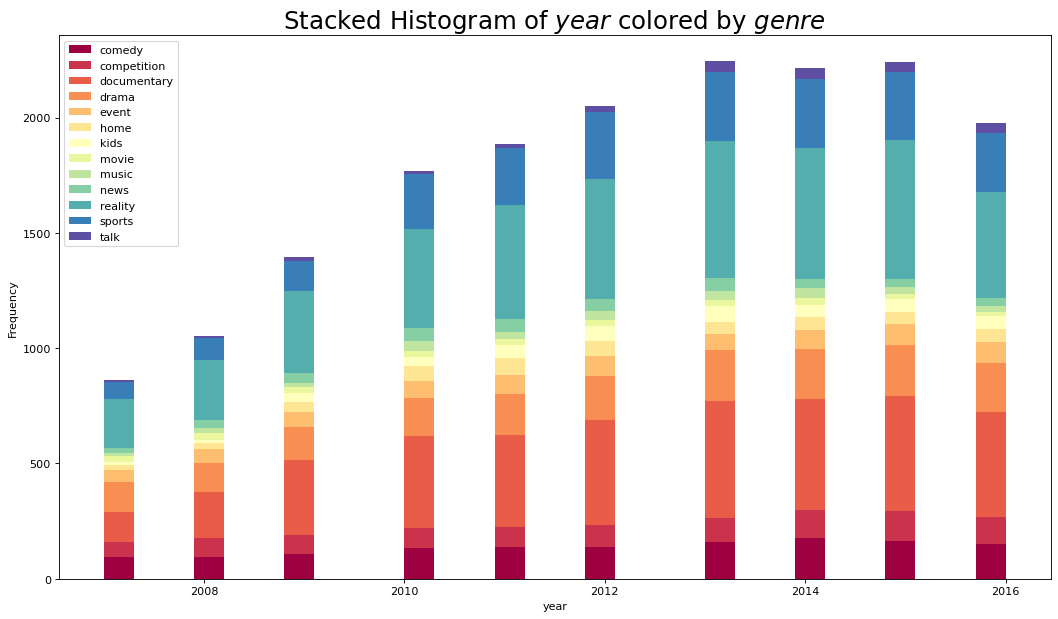

In [435]:
# Use cleaned programming schedule data
df = pd.read_csv("programmingcleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

## Histogram by number of unique shows per season over time
# grouping by year and season

df = df[df.isrepeat == 0]
df = df.drop_duplicates(['year','show'])


x_var = 'year'
groupby_var = 'genre'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, )
#plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

### Aggregating To Week

Programming schedules typically repeat every week and viewers can tune into their favorite shows by watching on a certain day at a certain time. Since schedules are programmed at this level I aggregate the hours of each genre of show to the week to compare across network.

In [581]:
# Use cleaned programming schedule data
df = pd.read_csv("programmingcleaned.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Create wkyear variable to collapse on
df['wkyear'] = df['date'].dt.strftime('%U-%Y')

dfweek = df.groupby(['network','genre','wkyear'], as_index=False).agg({'hours':sum})

# Pivot table so each obs. is network/wkyear with aggregate amounts as variables
df_wide = dfweek.pivot_table(
    index=['network','wkyear'],
    columns='genre',
    values=['hours'],
    fill_value=0
    ).reset_index()
# renames columns as combination of previous categories
df_wide.columns = list(map("".join, df_wide.columns))

# adds back week and year variables
dfyear = pd.DataFrame()    # creates a new dataframe for time elements
dfyear[['week','year']] = df_wide['wkyear'].str.split(pat = '-', expand=True)
df_wide = pd.concat([df_wide,dfyear], axis=1)
df_wide['year'] = pd.to_numeric(df_wide['year'])

In [582]:
df_wide.head()

,network,wkyear,hourscomedy,hourscompetition,hoursdocumentary,hoursdrama,hoursevent,hourshome,hourskids,hoursmovie,hoursmusic,hoursnews,hoursreality,hourssports,hourstalk,week,year
0,a&e,00-2009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00,2009
1,a&e,00-2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,00,2013
2,a&e,00-2014,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,00,2014
3,a&e,00-2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00,2015
4,a&e,00-2016,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00,2016


In [590]:
# Sum total hours per network per week
df_wide['tothours'] = df_wide['hourscomedy']+df_wide['hourscompetition']+df_wide['hoursdocumentary']+df_wide['hoursdrama']+df_wide['hoursevent']+df_wide['hourshome']+df_wide['hourskids']+df_wide['hoursmovie']+df_wide['hoursmusic']+df_wide['hoursnews']+df_wide['hoursreality']+df_wide['hourssports']+df_wide['hourstalk']

# drop if total hours are less than 15 minutes in a week
df_wide = df_wide[(df_wide['tothours']>0.01)]

#df_wide = df_wide.drop(columns = 'tothours')

In [593]:
# creates hours per genre as a proportion of 22 hr prime-time week, then makes a vector
hourslist = ['hourscomedy','hourscompetition','hoursdocumentary','hoursdrama','hoursevent','hourshome','hourskids','hoursmovie','hoursmusic','hoursnews','hoursreality','hourssports','hourstalk']
genrehours = df_wide[hourslist]

for column in genrehours:       # makes the proportions of genrehours/22
    df_wide[column] = df_wide[column]/22

#df_wide['genrevector'] = df_wide[hourslist].values.tolist() # creates a vector of genre proportions

#df_wide = df_wide.drop(columns = genrehours)    # drops genrehours variables

In [597]:
df_wide.to_csv("network_wkyear.csv", index=False)

## Ownership Data <a name="ownership"></a>

This data was collected from a combination of sources including network websites, FCC documents, press releases, and news articles. This is a document of dummy variables = 1 when a network is owned by a parent company, and 0 otherwise. This is combined onto the weekly data.

In [746]:
# Read the combined programming schedule data
dfno = pd.read_csv("networkownership.csv")

dfno.head()

,network,year,coverage,2929 Entertainment,ABSCBN,Al Jazeera Media Network,Amazon,AMCnetworks,AEG,BBC,Betfair,Big Ten Conference,Bloomberg,Bounce Media LLC,Cablevision,CBS,Charter,Comcast,cox,Creative Arts Agency,CrownMediaHoldings,Directv,Dish,Disney,DiscoveryCommunications,Essel Group,Gemstar,Harpo Productions,Hasbro,Hearst,here!,Hubbard,IMAX Corporation,Inspiration Media,Intermediapartners,ionmedia,Kroenke,libertymedia,LionsGate,Lucas Oil,madisonsquaregarden,Magic Johnson Enterprises,MarkCuban,MGM,MHz Networks,MLB,natgeosoc,NatCabSatCor,NBA,NBCUniversal,Netflix,NewsCorp,NFL,NHL,Outdoor Channel Holdings,Pac 12,Paramount,ParticipantMedia,PBS,Radio One,Retirement Living Tv,Robert Rodriguez,Rural Media Group,Ryan Seacrest Media,Scripps,Sean Combs,Sinclair,sitv,sonypicturestelevision,Smithsonian,Starz Inc,Tennis Inc,TimeWarner,Tribune,Univision,Verizon,Viacom,Vice Media,Yahoo
0,3net,2011,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3net,2012,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3net,2013,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3net,2014,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,A&E,2007,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [747]:
# Fix types network, coverage variables
dfno.network = dfno.network.astype(str).str.lower()

#dfno['coverage'] = dfno['coverage'].astype('Float64')            #destrings the coverage variable

In [748]:
prediff = pd.merge(df_wide, dfno, how="left", on=['network','year'])

In [749]:
prediff.to_csv("prediff.csv", index=False)

# Differentiation Measure <a name="differentiation"></a>

To measure the difference between two network's schedules I use the [cosine distance measure](https://en.wikipedia.org/wiki/Cosine_similarity). This measure looks at the angle between two vectors of numerical values, in this case each dimension of the vector is the proportion of a weekly schedule that is devoted to a genre. The distance measure is interpreted as follows

- 0 = the schedules for both networks have the same proportions of every genre  

- 1 = the schedules have no overlap in the genres they aired.

The elemeents of the vectors were made earlier. This code creates the vectors, makes a combination of all networks that have data in the same week and year, then creates variables to assess the affects of the mergers.




In [827]:
# Read in network per week data
diffmeas = pd.read_csv('prediff.csv')
diffmeas.sort_values(by = ['wkyear', 'network'])

# The following pulls out a slice that is useful for testing code not on the full data set
#diffmeas = diffmeas.query('network == "abc" and year == "2010" or network == "nbc" and year == "2010" or network == "disney" and year == "2010"').reset_index(drop=True)

diffmeas.head()

,network,wkyear,hourscomedy,hourscompetition,hoursdocumentary,hoursdrama,hoursevent,hourshome,hourskids,hoursmovie,hoursmusic,hoursnews,hoursreality,hourssports,hourstalk,week,year,tothours,coverage,2929 Entertainment,ABSCBN,Al Jazeera Media Network,Amazon,AMCnetworks,AEG,BBC,Betfair,Big Ten Conference,Bloomberg,Bounce Media LLC,Cablevision,CBS,Charter,Comcast,cox,Creative Arts Agency,CrownMediaHoldings,Directv,Dish,Disney,DiscoveryCommunications,Essel Group,Gemstar,Harpo Productions,Hasbro,Hearst,here!,Hubbard,IMAX Corporation,Inspiration Media,Intermediapartners,ionmedia,Kroenke,libertymedia,LionsGate,Lucas Oil,madisonsquaregarden,Magic Johnson Enterprises,MarkCuban,MGM,MHz Networks,MLB,natgeosoc,NatCabSatCor,NBA,NBCUniversal,Netflix,NewsCorp,NFL,NHL,Outdoor Channel Holdings,Pac 12,Paramount,ParticipantMedia,PBS,Radio One,Retirement Living Tv,Robert Rodriguez,Rural Media Group,Ryan Seacrest Media,Scripps,Sean Combs,Sinclair,sitv,sonypicturestelevision,Smithsonian,Starz Inc,Tennis Inc,TimeWarner,Tribune,Univision,Verizon,Viacom,Vice Media,Yahoo
0,a&e,00-2009,0.0,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,2009,1.0,0.8561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,a&e,00-2013,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0,2013,4.0,0.8608,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,a&e,00-2014,0.0,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0,2014,2.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,a&e,00-2015,0.0,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,2015,1.0,0.8160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,a&e,00-2016,0.0,0.0,0.090909,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,2016,3.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [828]:
# Create a dataframe of all combinations of network within wkyear

from itertools import combinations

# Create a DataFrame of just weeks and networks
dfcombo1 = diffmeas[['wkyear','network']]


# makes a combination of all networks within wkyear groups 
dfcombo2 = (dfcombo1.groupby('wkyear')['network'].apply(lambda x: pd.DataFrame(list(combinations(x,2))))
        .reset_index(level=1, drop=True)
        .reset_index())
dfcombo2.columns = ['wkyear','network','network2']


In [829]:
#  Creates the second network's variables to be merged with the combinations of networks
diffmeas2 = diffmeas.copy()          # Creates a copy of diffmeas to merge using network 2 

diffmeas2.columns = [str(col)+'2' for col in diffmeas2.columns]          # adds a 2 to all column names
diffmeas2.rename(columns={'wkyear2':'wkyear'}, inplace=True)          # rename wkyear so it can be merged


In [830]:
# Merges the both network's genre vector and ownership information
diff = pd.merge(dfcombo2, diffmeas, how="left", on=['network','wkyear'])          # merges first network data
diff = pd.merge(diff, diffmeas2, how="left", on=['network2','wkyear'])          # merges second network data



### netpairs and common ownership

creates variables to identify when a network pair are owned by the same firm.

In [831]:
# Makes a network pair variable
diff['netpair'] = diff['network'] + diff['network2']


In [832]:
# The obnoxious way of creating the differentiation measure
diff['numerator'] = diff['hourscomedy']*diff['hourscomedy2'] + diff['hourscompetition']*diff['hourscompetition2'] + diff['hoursdocumentary']*diff['hoursdocumentary2'] + diff['hoursdrama']*diff['hoursdrama2'] + diff['hoursevent']*diff['hoursevent2'] + diff['hourshome']*diff['hourshome2'] + diff['hourskids']*diff['hourskids2'] + diff['hoursmovie']*diff['hoursmovie2'] + diff['hoursmusic']*diff['hoursmusic2'] + diff['hoursnews']*diff['hoursnews2'] + diff['hoursreality']*diff['hoursreality2'] + diff['hourssports']*diff['hourssports2'] + diff['hourstalk']*diff['hourstalk2']

diff['denominator1'] = np.sqrt( np.square(diff['hourscomedy']) + np.square(diff['hourscompetition']) + np.square(diff['hoursdocumentary']) + np.square(diff['hoursdrama']) + np.square(diff['hoursevent'])+ np.square(diff['hourshome']) + np.square(diff['hourskids']) + np.square(diff['hoursmovie']) + np.square(diff['hoursmusic']) + np.square(diff['hoursnews']) + np.square(diff['hoursreality'])+ np.square(diff['hourssports']) + np.square(diff['hourstalk']))
diff['denominator2'] = np.sqrt( np.square(diff['hourscomedy2']) + np.square(diff['hourscompetition2']) + np.square(diff['hoursdocumentary2']) + np.square(diff['hoursdrama2']) + np.square(diff['hoursevent2'])+ np.square(diff['hourshome2']) + np.square(diff['hourskids2']) + np.square(diff['hoursmovie2']) + np.square(diff['hoursmusic2']) + np.square(diff['hoursnews2']) + np.square(diff['hoursreality2'])+ np.square(diff['hourssports2']) + np.square(diff['hourstalk2']))

diff['sim'] = diff['numerator']/(diff['denominator1']*diff['denominator2'])

diff['dist'] = 1 -diff['numerator']/(diff['denominator1']*diff['denominator2'])

In [833]:
# Creating commonowner variable = 1 when both networks in pair are owned by same firm, 0 otherwise
diff['commonowner'] = np.nan
diff['commonowner'] = np.where(diff.loc[:,'2929 Entertainment':'Yahoo'].eq(diff.loc[:,'2929 Entertainment2':'Yahoo2'].to_numpy()).all(axis=1),1,0)


In [834]:
diff.to_csv("diff.csv", index=False)

### Identifying mergers, pre and post merger variables

Creates variables for the merger analysis.

In [ ]:
# read in the data
diff = pd.read_csv('diff.csv')


In [836]:
# DF organized by just netpair and year to identify commonowner changes

dfchangeowner = diff.groupby(['netpair','year'], as_index=False).agg({'commonowner':'mean'})

dfchangeowner['change'] = dfchangeowner.groupby(['netpair'])['commonowner'].diff()
dfchangeowner['change'].fillna(0, inplace=True)

In [837]:
dfchangeowner['merged'] = dfchangeowner['change'].groupby(dfchangeowner['netpair']).transform('sum')

In [838]:
# creates the postmerge variable, but only for netpairs that merge
dfchangeowner['postmerge'] = dfchangeowner[dfchangeowner['merged']==1].groupby('netpair')['change'].cumsum()


In [839]:
# Creates the premerge variable, but only for netpairs that merge
def reverse(x,y):
    if x < 1 and y > 0:
        return 1
    elif x > 0 and y > 0:
        return 0
    else: return np.nan

    
func = np.vectorize(reverse)
dfchangeowner['premerge'] = func(dfchangeowner['postmerge'],dfchangeowner['merged'])    
    

In [840]:
# Merges merger identifiers back to full data set
diff = pd.merge(diff, dfchangeowner, how="left", on=['netpair','year'])

In [841]:
# Create tv season dummies by week
## Spring: January - May
## Summer: June - August
## Winter: September - December

seasonconditions = [
    (diff['week'] <= 20),
    (diff['week'] > 20) & (diff['week'] <35),
    (diff['week'] >= 36)
]

seasonvalues = ['spring','summer','fall']

diff['season'] = np.select(seasonconditions, seasonvalues)

In [842]:
# create a time variable for analysis and graphs
diff['weeks'] = pd.to_datetime(diff.year.astype(str), format='%Y') + \
             pd.to_timedelta(diff.week.mul(7).astype(str) + ' days')

In [843]:
len(diff)

1595605

In [844]:
diff.to_csv("diff2.csv", index=False)

## Cosine Distance Measure

# Analysis <a name="analysis"></a>

**How do programming schedules change after mergers?**  

Here I show an event study analysis using the differences-in-differences techniques. The network pairs that merged between 2007 and 2016 are the "treated group" and the "control group" are network pairs that did not. This method lends itself to time based changes as we can compare pre and post merger. To simplify the evaluation I assume that the merger occurs at the beginning of the year that the merger occurs although that timing is not true of the merger dates. Additionally, it is likely that the timing of changing the programming lineup takes time beyond the initial merger date. For a fuller discussion of the timing and choices in this methodology I invite you to read the paper draft.

The simplest analysis of the effect of the mergers is to compare the cosine distance within the firms that merged. The following code takes the difference between the cosine distance of network pairs that merge before and after the merger.

In [807]:
merged_before = diff.query('merged == 1 & postmerge == 0')['dist'].mean()
merged_after = diff.query('merged == 1 & postmerge == 1')['dist'].mean()
merged_diff = merged_after - merged_before 

print('Before the mergers these network pairs have a cosine distance of', merged_before, 'and after the merger', merged_after,'. the change from before to after is', merged_diff)

Before the mergers these network pairs have a cosine distance of 0.744923144206541 and after the merger 0.7093731973997137 . the change from before to after is -0.035549946806827326


This suggests that on average networks that merged showed more similar programming after the merger. However, we don't know if this difference is because the networks that merge are different than networks that don't or if the difference is from trends affecting all networks like reality tv becoming more popular. 

To address these questions we need to use a control group as a comparison, in this case the firms that did not merge in this time period. However, that brings up another issue in that several mergers occur in this data set at different times. 

## Analysis of Mergers in 2013

The following netpairs were merged in 2013

In [863]:
mrg2013 = dfchangeowner.query('merged == 1 and change == 1 and year == 2013')['netpair'].tolist()

mrg2013

['a&ebio',
 'a&eespn',
 'a&eespn2',
 'a&eespnu',
 'a&eh2',
 'biohistory',
 'espn2history',
 'espn2lifetime',
 'espn2lmn',
 'espnhistory',
 'espnuhistory',
 'espnulifetime',
 'espnulmn',
 'h2history',
 'h2lifetime',
 'h2lmn']

We can do the same analysis of pre and post cosine distance for the network pairs that merged in this year, but now we will also compare this change to all of the netpairs that never merged in this time span.

In [939]:
# Makes two data frames one for netpairs that merged and one for netpairs that didn't
mergers = diff.query('merged == 1')
nomergers = diff.query('merged == 0')

In [940]:
# makes a dataframe from the netpairs that merged in 2013
dfm13 = mergers[~mergers['netpair'].isin(mrg2013)]

#combines it with control group netpairs
df13 = pd.concat([nomergers,dfm13]).reset_index()

df13['postmerge'] = np.where((df13['weeks'] >= '2013-01-01'), 1, 0)

In [941]:
# Calculate comparison statistics

merged_before = df13.query('merged == 1 & postmerge == 0')['dist'].mean()
merged_after = df13.query('merged == 1 & postmerge == 1')['dist'].mean()
merged_diff = merged_after - merged_before 

nomerged_before = df13.query('merged == 0 & postmerge == 0')['dist'].mean()
nomerged_after = df13.query('merged == 0 & postmerge == 1')['dist'].mean()
nomerged_diff = nomerged_after - nomerged_before 

diff_in_diff = merged_diff - nomerged_diff

print('The difference for the merged group is', merged_diff, 'and for the nonmerged group is', nomerged_diff, '. Using the control group of netpairs that never merged we see the overall effect of the mergers is', diff_in_diff)      

The difference for the merged group is -0.03399945947696159 and for the nonmerged group is 0.007901730037514598 . Using the control group of netpairs that never merged we see the overall effect of the mergers is -0.04190118951447619


Assuming that all netpairs would have the same trend without the intervention of a merger we see that overall effect is that the merged networks become less diverse than if they had not merged!

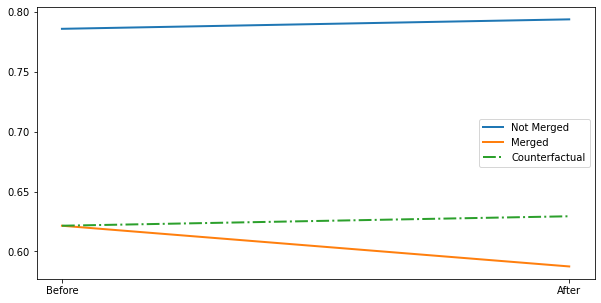

In [942]:
plt.figure(figsize=(10,5))
plt.plot(["Before", "After"], [nomerged_before, nomerged_after], label="Not Merged", lw=2)
plt.plot(["Before", "After"], [merged_before, merged_after], label="Merged", lw=2)

plt.plot(["Before", "After"], [merged_before, merged_before+(nomerged_after-nomerged_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

In this graph the distance between the yellow line and the green line at the "after" point is the difference in difference estimator

Finally, here is this same approach using a regression:

In [943]:
 smf.ols('dist ~ merged*postmerge', data=df13).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7859,0.000,2049.774,0.000,0.785,0.787
merged,-0.1644,0.005,-30.351,0.000,-0.175,-0.154
postmerge,0.0079,0.001,15.352,0.000,0.007,0.009
merged:postmerge,-0.0419,0.008,-5.072,0.000,-0.058,-0.026


An important assumption of this method is that the control group and the treatment group have similar pretrends. There's no explicit test for what makes a similar pretrend, but we can look at it graphically:

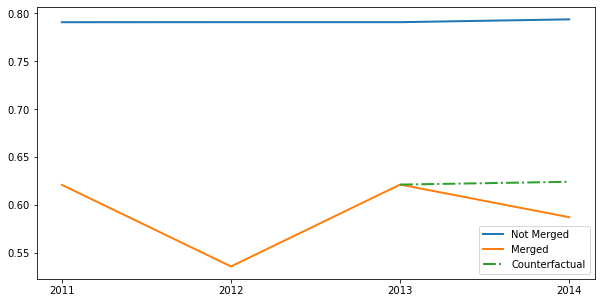

In [964]:
nomerged_before11 = df13.query('merged == 0 & postmerge == 0 & year == 2011')['dist'].mean()
nomerged_before12 = df13.query('merged == 0 & postmerge == 0 & year == 2012')['dist'].mean()

merged_before11 = df13.query('merged == 1 & postmerge == 0 & year == 2011')['dist'].mean()
merged_before12 = df13.query('merged == 1 & postmerge == 0 & year == 2012')['dist'].mean()

plt.figure(figsize=(10,5))
x = ["2011", "2012", "2013", "2014"]

plt.plot(x, [nomerged_before11, nomerged_before12, nomerged_before,  nomerged_after], label="Not Merged", lw=2)
plt.plot(x, [merged_before11, merged_before12, merged_before, merged_after], label="Merged", lw=2)

plt.plot(["2013", "2014"], [merged_before, merged_before+(nomerged_after-nomerged_before)], label="Counterfactual", lw=2, color="C2", ls="-.")


plt.legend();

The trend for the merged group is not very similar in the period shown here because of the big dip in 2012. Although between 2011 and 2013 the trend is more parallel to the not merged firms. The takeaway from the graph and the previous results is that this group of firms that merged tended to be more similar than the average never merged networks.